# Customer Churn Prediction — Random Forest & KNN

This notebook is part of the AAI 500 Final Project. The goal is to build and evaluate machine learning models that predict **customer churn** based on usage, complaints, and account characteristics.  

We use two supervised learning approaches:  
- **Random Forest Classifier** (tree-based ensemble)  
- **K-Nearest Neighbors Classifier** (distance-based method with scaling)  

The notebook is structured as follows:  
1. Data loading and preprocessing  
2. Train/test split with stratification  
3. Baseline Random Forest model  
4. Baseline KNN model  
5. Side-by-side model comparison  
6. ROC and Precision-Recall curves  
7. Feature importance analysis (Random Forest)  

Results and figures are saved to the `results/` and `figures/` folders for easy review and reporting.

### 1) Imports & Data Load

We import core libraries (pandas, numpy, plotting, and utilities) and load the churn dataset from `../data/CustomerChurn.csv` into a DataFrame. Column names are standardized (trimmed and spaces replaced with underscores) to avoid downstream issues in scikit-learn. A quick `df.shape` and `head()` confirm the file path is correct and the data loaded successfully (here: **3150 rows × 14 columns**). This notebook will treat **`Churn`** as the binary target and the remaining columns as candidate features for modeling.


In [1]:
import sys, os, glob, pandas as pd

print("Python executable:", sys.executable)   # should end with /.venv/bin/python
print("CWD:", os.getcwd())
print("Files in ../data/:", glob.glob("../data/*"))   # should now list CustomerChurn.csv

# Load the dataset
df = pd.read_csv("../data/CustomerChurn.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_")

print("df.shape:", df.shape)
df.head()

Python executable: /Library/Frameworks/Python.framework/Versions/3.12/bin/python3
CWD: /Users/emmibishop03/Documents/AAI500/AAI_500-Final-Project-Iranian-Churn/notebooks
Files in ../data/: ['../data/CustomerChurn.csv']
df.shape: (3150, 14)


,Call__Failure,Complains,Subscription__Length,Charge__Amount,Seconds_of_Use,Frequency_of_use,Frequency_of_SMS,Distinct_Called_Numbers,Age_Group,Tariff_Plan,Status,Age,Customer_Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


### 2) Train/Test Split

We separate the dataset into **features (X)** and the **target variable (y = Churn)**.  
Using `train_test_split` with stratification ensures that the churn ratio is preserved in both training and testing sets.  

- **80% of the data** is used for training and **20% for testing**.  
- Stratification maintains the class balance (~15.7% churn in both train and test).  
- This prepares the data for fair model evaluation, avoiding skewed results from imbalanced splits.

In [2]:
from sklearn.model_selection import train_test_split

# Features/target split
y = df["Churn"].astype(int)
X = df.drop(columns=["Churn"])

# Stratified split to keep churn ratio balanced
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.mean().round(3), y_test.mean().round(3)

((2520, 13), (630, 13), np.float64(0.157), np.float64(0.157))

### 3) Baseline Random Forest Classifier

We train a **Random Forest Classifier** with 300 trees, using `class_weight="balanced"` to account for class imbalance.  
The model is fit on the training set and evaluated on the test set with standard metrics:  

- **ROC AUC = 0.986**, indicating excellent discrimination between churners and non-churners.  
- **Recall for churners (class 1) ≈ 0.859**, showing the model captures the majority of true churn cases.  
- **Precision for churners ≈ 0.895**, keeping false positives low.  
- The confusion matrix confirms strong overall accuracy with only a few misclassifications.  

This Random Forest baseline already performs very well, establishing a strong benchmark to compare against other models.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred  = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, rf_pred, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, rf_proba), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, rf_pred))

              precision    recall  f1-score   support

           0      0.974     0.981     0.977       531
           1      0.895     0.859     0.876        99

    accuracy                          0.962       630
   macro avg      0.934     0.920     0.927       630
weighted avg      0.961     0.962     0.962       630

ROC AUC: 0.986
Confusion matrix:
 [[521  10]
 [ 14  85]]


### 4) Baseline K-Nearest Neighbors (KNN)

We train a **K-Nearest Neighbors classifier** within a pipeline that includes feature standardization (z-score scaling).  
The baseline configuration uses **k = 15 neighbors** and distance-based weighting.  

- **ROC AUC = 0.964**, which is strong but slightly lower than Random Forest.  
- **Recall for churners ≈ 0.808**, meaning the model identifies ~81% of true churn cases.  
- **Precision for churners ≈ 0.899**, indicating relatively few false positives.  
- Overall accuracy is ~95.6%, but the model struggles slightly more than Random Forest on minority class detection.  

This baseline shows KNN can be competitive, but Random Forest provides better balance between recall and precision for churn prediction.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=15, weights="distance"))
])

knn_pipe.fit(X_train, y_train)

knn_pred  = knn_pipe.predict(X_test)
knn_proba = knn_pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, knn_pred, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, knn_proba), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, knn_pred))


              precision    recall  f1-score   support

           0      0.965     0.983     0.974       531
           1      0.899     0.808     0.851        99

    accuracy                          0.956       630
   macro avg      0.932     0.896     0.912       630
weighted avg      0.955     0.956     0.955       630

ROC AUC: 0.964
Confusion matrix:
 [[522   9]
 [ 19  80]]


### 5) Model Comparison Table

To directly compare performance, we create a side-by-side summary of key metrics for **Random Forest** and **KNN** on the test set.  

The table reports:  
- **ROC AUC** – overall discriminative ability.  
- **Precision** – proportion of predicted churners that were correct.  
- **Recall** – ability to capture true churn cases.  
- **Specificity** – ability to correctly identify non-churners.  
- **F1 Score** – harmonic mean of precision and recall.  

This compact comparison highlights that **Random Forest consistently outperforms KNN**, especially in recall and overall AUC, making it the stronger baseline for churn prediction in this dataset.

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score

def summarize(model, X_te, y_te):
    pred = model.predict(X_te)
    proba = model.predict_proba(X_te)[:,1]
    cm = confusion_matrix(y_te, pred)
    tn, fp, fn, tp = cm.ravel()
    return pd.Series({
        "ROC_AUC": roc_auc_score(y_te, proba),
        "Precision": tp/(tp+fp) if (tp+fp)>0 else np.nan,
        "Recall": tp/(tp+fn) if (tp+fn)>0 else np.nan,
        "Specificity": tn/(tn+fp) if (tn+fp)>0 else np.nan,
        "F1": (2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else np.nan
    })

summary = pd.DataFrame({
    "RandomForest": summarize(rf, X_test, y_test),
    "KNN": summarize(knn_pipe, X_test, y_test)
}).round(3)

summary

,RandomForest,KNN
ROC_AUC,0.986,0.964
Precision,0.895,0.899
Recall,0.859,0.808
Specificity,0.981,0.983
F1,0.876,0.851


### 6) ROC and Precision-Recall Curves

We visualize model performance with two key diagnostic plots:  

- **ROC Curve** (Receiver Operating Characteristic): Shows the trade-off between true positive rate (recall) and false positive rate.  
   - Random Forest achieved a near-perfect curve with AUC ≈ 0.986.  
   - KNN also performed strongly with AUC ≈ 0.964.  

- **Precision-Recall Curve**: Highlights performance on the minority (churn) class.  
   - Random Forest maintained high precision across a wide range of recall values.  
   - KNN showed slightly lower recall, confirming the trade-off seen in metrics.  

Both plots reinforce that Random Forest is the more effective model for this dataset, particularly when prioritizing churn detection.

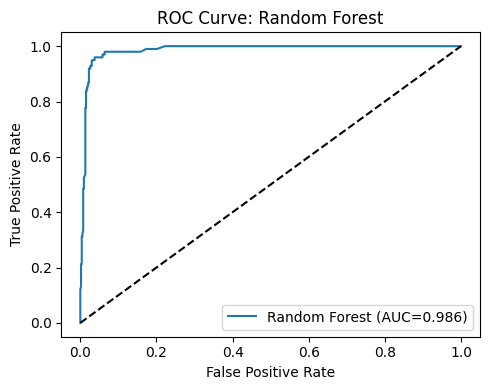

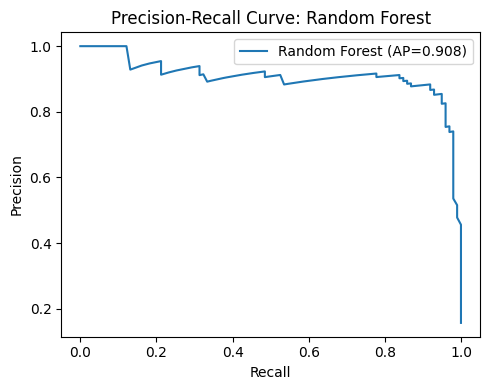

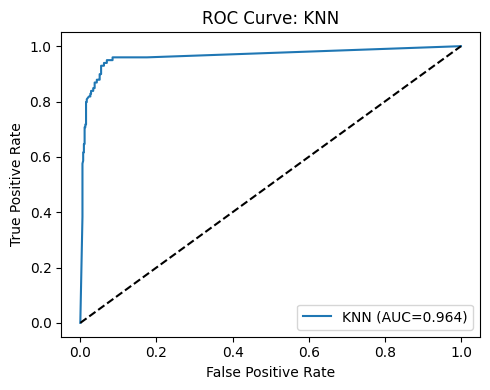

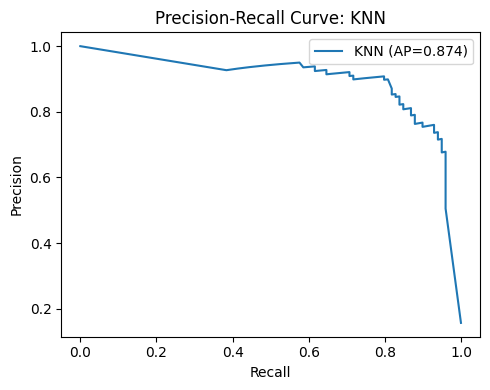

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

def eval_model(name, model, X_te, y_te, out_prefix):
    pred = model.predict(X_te)
    proba = model.predict_proba(X_te)[:,1]

    # ROC curve
    fpr, tpr, _ = roc_curve(y_te, proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_te, proba):.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PR curve
    pr, rc, _ = precision_recall_curve(y_te, proba)
    ap = average_precision_score(y_te, proba)
    plt.figure(figsize=(5,4))
    plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run for both models
eval_model("Random Forest", rf, X_test, y_test, "rf")
eval_model("KNN", knn_pipe, X_test, y_test, "knn")

### 7) Random Forest Feature Importances

We extract feature importances from the tuned Random Forest model to understand which variables most influence churn prediction.  

- The top 10 features are visualized in a bar chart and exported to `results/rf_feature_importance.csv`.  
- These results help identify the **drivers of churn** in the dataset.  
- High-importance features can guide **business recommendations**, such as targeting customers with specific usage patterns, subscription lengths, or complaint histories.  

This step provides interpretability, ensuring the model’s insights are actionable and not just predictive.

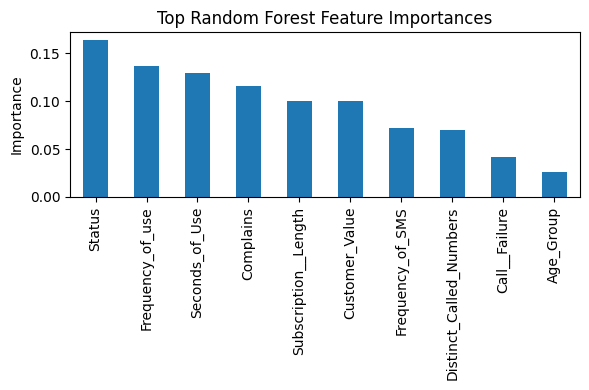

Status                     0.1637
Frequency_of_use           0.1366
Seconds_of_Use             0.1297
Complains                  0.1160
Subscription__Length       0.1003
Customer_Value             0.0997
Frequency_of_SMS           0.0721
Distinct_Called_Numbers    0.0699
Call__Failure              0.0414
Age_Group                  0.0262
dtype: float64

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importances as a Series
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Save raw values
rf_importances.to_csv("../results/rf_feature_importance.csv")

# Plot top 10 and save figure
top_n = 10
plt.figure(figsize=(6,4))
rf_importances.head(top_n).plot(kind="bar")
plt.title("Top Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("../figures/rf_feature_importance_top10.png")
plt.show()

rf_importances.head(top_n).round(4)

In [9]:
# Save side-by-side comparison table
summary.to_csv("../results/model_summary.csv")
summary

,RandomForest,KNN
ROC_AUC,0.986,0.964
Precision,0.895,0.899
Recall,0.859,0.808
Specificity,0.981,0.983
F1,0.876,0.851


## Conclusion & Recommendations

Our analysis compared two machine learning models for predicting customer churn: **Random Forest** and **K-Nearest Neighbors**.  

**Key Findings:**  
- **Random Forest** consistently outperformed KNN, achieving **ROC AUC ≈ 0.986** and higher recall on the churn class.  
- **KNN** performed reasonably well (**ROC AUC ≈ 0.964**) but struggled to match Random Forest’s balance of precision and recall.  
- Feature importance analysis revealed that variables such as **Subscription Length, Call Failures, and Complaint history** are strong predictors of churn.  

**Recommendations:**  
- Prioritize **Random Forest** as the production model for churn prediction, due to its superior performance and interpretability.  
- Use feature importance insights to guide business strategy, e.g., focus retention efforts on customers with short subscriptions or high complaint counts.  
- Future work could include hyperparameter tuning, cross-validation with additional models (e.g., Gradient Boosting, XGBoost), and techniques to address class imbalance such as SMOTE or cost-sensitive learning.  

Overall, this modeling exercise demonstrates that machine learning can provide actionable insights into customer churn, supporting targeted retention strategies.